# CoRaLS Monte Carlo acceptance model 

This will step through a the main Monte Carlo model and plot some results.

In [1]:
# Import and compile modules - slow the first time you run on a fresh kernel
using Printf
using CoRaLS
using ProgressMeter
using PyPlot
using LaTeXStrings
using DelimitedFiles
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip

[ Info: Precompiling CoRaLS [9de490ff-36bf-45aa-ac77-c1e4634bf958]


LoadError: ArgumentError: Package ProgressMeter not found in current path.
- Run `import Pkg; Pkg.add("ProgressMeter")` to install the ProgressMeter package.

In [2]:
# Number of trials and energy bins in each run
ntrials = Int(1e5)
nbins = 20
altitude = 40km
trigger = gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m)
# trigger = magnitude_trigger(100μV / m)

A = acceptance(ntrials, nbins; 
               altitude=altitude, 
               ice_depth=6.0m,
               min_energy=1.0EeV,
               ν_max=1000MHz,
               dν=30MHz,
               trigger=trigger,
               save_events=false)
# Energy bins and acceptances are in: A.energies, A.dAΩ, A.rAΩ

E_bins = 18.0 .+ log10.(0.5*(A.energies[1:end-1] + A.energies[2:end]) / 1.0EeV)
A_direct = A.dAΩ / 1km^2 / 1sr
A_reflected = A.rAΩ / 1km^2 / 1sr;  # semicolon suppresses output

┌ Info: Calculating acceptance using 10000 trials across 10 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:56
Simulating... 100%|██████████████████████████████████████| Time: 0:00:18


In [3]:
println("Nvisible: ", size(A.reflected)[1])
dtrig = [t for t in A.direct if t.triggered]
rtrig = [t for t in A.reflected if t.triggered]
println(size(dtrig), dtrig)
println(size(rtrig), rtrig)
Emax = sort([maximum(ustrip.(e.Ef)) for e in rtrig])

Nvisible: 42188
(128,)CoRaLS.Direct[DirectEvent(4.416179524271415 EeV, -16.179166568867977), DirectEvent(10.820929591980665 EeV, -18.749034480561306), DirectEvent(11.52561334305289 EeV, -12.887526424354505), DirectEvent(6.87312453746663 EeV, -31.71032458604666), DirectEvent(19.8335028137462 EeV, -18.9592122248397), DirectEvent(17.51710932589708 EeV, -15.845914915060055), DirectEvent(16.18785769924307 EeV, -18.57910398134257), DirectEvent(43.50674044370142 EeV, -21.288128634441733), DirectEvent(29.325581719974338 EeV, -41.9462965542174), DirectEvent(75.39976558270605 EeV, -46.31986380064959), DirectEvent(75.68494393860705 EeV, -26.31250894958507), DirectEvent(53.370654007965 EeV, -23.511414751303548), DirectEvent(64.19964898448968 EeV, -24.9422928339061), DirectEvent(51.44930549962304 EeV, -19.009698172884306), DirectEvent(51.251852042579046 EeV, -16.284502897676493), DirectEvent(73.95775175658076 EeV, -13.911903097089478), DirectEvent(48.175633307057 EeV, -22.733926582537535), DirectEv

2420-element Vector{Float64}:
   1.160643586841931
   1.701817688481511
   1.8339543083690844
   1.8357968611437163
   1.8495999955645765
   1.8535024414412247
   1.8783423290543848
   1.9291205951994388
   1.9299213784018983
   2.0008508018054307
   ⋮
 168.7818569109452
 174.04070436757166
 185.2102843954392
 198.59974405397008
 210.8206079818688
 235.12910278419514
 239.02220170505203
 241.8367009745774
 273.9531928954309

In [20]:
# Number of trials and energy bins in each run
ntrials = 500000  # Baseline test: 100_000
nbins = 10  # Baseline test: 20

B = acceptance( ntrials, nbins; 
                altitude=altitude, 
                ice_depth=ice_depth,
                min_energy=1.0EeV,
                ν_max=1000MHz,
                dν = 30MHz,
                trigger=gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m),
                save_events=true, orbit=true)


┌ Info: Calculating acceptance using 500000 trials across 10 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:56
Simulating... 100%|██████████████████████████████████████| Time: 0:00:20


CoRaLS.Acceptance(500000, 40 km, Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr], Unitful.Quantity{Float64, 𝐋^2 𝐌 𝐓^-2, Unitful.FreeUnits{(EeV,), 𝐋^2 𝐌 𝐓^-2, nothing}}[1.0 EeV, 1.8958986836690466 EeV, 3.5944318187380233 EeV, 6.814678553683553 EeV, 12.919940099556333 EeV, 24.494897427831773 EeV, 46.439843790034566 EeV, 88.0452387113227 EeV, 166.92485217612372 EeV, 316.47260751236286 EeV, 599.9999999999997 EeV], Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[0.0 km^2 sr, 0.0 km^2 sr, 0.0 km^2 sr, 238.33584658114268 km^2 sr, 1906.6867726491414 km^2 sr, 953.3433863245707 km^2 sr, 2383.3584658114273 km^2 sr, 5005.052778203996 km^2 sr, 6673.

In [21]:
println("Nvisible: ", size(B.reflected)[1])
dtrig = [t for t in B.direct if t.triggered]
rtrig = [t for t in B.reflected if t.triggered]
println(size(dtrig), dtrig)
println(size(rtrig), rtrig)
Emax = sort([maximum(ustrip.(e.Ef)) for e in rtrig])

Nvisible: 45568
(122,)CoRaLS.Direct[DirectEvent(7.644946746581523 EeV, -29.935175109834095), DirectEvent(21.300974037733013 EeV, -16.821973284385138), DirectEvent(14.756999968160152 EeV, -17.193054857258975), DirectEvent(21.536853015830616 EeV, -13.110916928192564), DirectEvent(15.10852142861086 EeV, -34.33639814644053), DirectEvent(15.805421141573362 EeV, -21.492221562685277), DirectEvent(22.049501707503186 EeV, -32.220067271862966), DirectEvent(14.716300664512373 EeV, -37.1106743294373), DirectEvent(14.822064204193218 EeV, -15.04284420916426), DirectEvent(33.68182460369213 EeV, -18.094879926942635), DirectEvent(25.86564091168716 EeV, -17.03809920009003), DirectEvent(33.926775516287925 EeV, -13.393000605398559), DirectEvent(29.513752025405118 EeV, -12.97650913182891), DirectEvent(48.61016119830681 EeV, -12.930138185798548), DirectEvent(46.61400938989268 EeV, -17.178771334080032), DirectEvent(52.66304248642089 EeV, -17.52460230703195), DirectEvent(58.36144341466136 EeV, -12.21845807933

Excessive output truncated after 524333 bytes.

, ReflectedEvent(417.2048407778509 EeV, -15.395721493851696), ReflectedEvent(338.85471841651497 EeV, -12.178510127491789), ReflectedEvent(461.6051137262061 EeV, -13.323149085946419), ReflectedEvent(370.65827425263495 EeV, -13.32247626554421), ReflectedEvent(320.0297665124574 EeV, -14.269292903312314), ReflectedEvent(515.0898766824904 EeV, -13.86024336584251), ReflectedEvent(359.00517102628737 EeV, -17.5437685868772), ReflectedEvent(324.04344379256673 EeV, -12.914432276965544), ReflectedEvent(459.8318575458527 EeV, -22.589297588877066), ReflectedEvent(326.2638560796288 EeV, -18.822854754839934), ReflectedEvent(419.62910486744767 EeV, -12.978993631790237), ReflectedEvent(420.02914629556267 EeV, -14.721024588182347), ReflectedEvent(372.552084047491 EeV, -34.42225566948855), ReflectedEvent(402.02923420080555 EeV, -12.205500322895963), ReflectedEvent(418.74551797548673 EeV, -12.237018676801432), ReflectedEvent(450.6823829881947 EeV, -12.871847046492382), ReflectedEvent(328.3514902465517 EeV

2257-element Vector{Float64}:
   1.2222389829667972
   1.4225686117190393
   1.5544727572293096
   1.5836295897174562
   1.8048455817952254
   1.8324715400790543
   1.8370911759003499
   1.8518450953952237
   1.9274297178829756
   1.944839331101558
   ⋮
 174.48062671409693
 176.1596017207599
 177.79661109087016
 193.82743958273917
 198.7601259416844
 203.301711915692
 244.18639814307033
 249.64959584332684
 262.26940639677565

In [23]:
Nvis = size(B.reflected)[1]
Npsr = sum([1 for e in B.reflected if e.is_psr])
Npolar = sum([1 for e in B.reflected if e.is_polar])
Nmare = sum([1 for e in B.reflected if e.is_mare])
Nequator = sum([1 for e in B.reflected if e.is_equator])
Amoon = 4 * pi * Rmoon^2 / km^2
Apsr = 1.2866e4 + 1.6055e4  # [km^2] North pole + South pole (Mazarico 2011)
Apolar = 2 * spherical_cap_area(deg2rad(10)) / km^2
Aequator = Amoon - (2*spherical_cap_area(deg2rad(85)) / km^2)
Amare = 6.15e6  # [km^2] (Nelson 2016)
println("Visible events: $(Nvis)")
println("PSR  \t\t $(Npsr)/$(Nvis) ($(@sprintf("%.2f",100*Npsr/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Apsr/Amoon))%")
println("Polar\t\t $(Npolar)/$(Nvis) ($(@sprintf("%.2f",100*Npolar/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Apolar/Amoon))%")
println("Mare \t\t $(Nmare)/$(Nvis) ($(@sprintf("%.2f",100*Nmare/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Amare/Amoon))%")
println("Equator (5S,5N)\t $(Nequator)/$(Nvis) ($(@sprintf("%.2f",100*Nequator/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Aequator/Amoon))%")

In [36]:
# Failure modes
sizes_direct = [0 for _ in 1:7]
sizes_reflected = [0 for _ in 1:7]
for signal in B.failed_direct
    sizes_direct[Int(signal)+1] += 1
end
for signal in B.failed_reflected
    sizes_reflected[Int(signal)+1] += 1
end
println(["Upgoing", "TIR", "XmaxAfterIce", "NoXmax", "NotPSR", "NotVisible", "NotPolar"])
print(sizes_reflected)

["Upgoing", "TIR", "XmaxAfterIce", "NoXmax", "NotPSR", "NotVisible", "NotPolar"]
[0, 226, 0, 0, 0, 98872, 0]

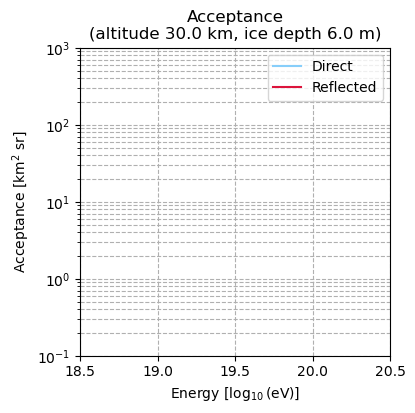

In [3]:
# Plot results
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(E_bins, A_direct, label="Direct", c="lightskyblue", ls="solid")
ax.plot(E_bins, A_reflected, label="Reflected", c="crimson", ls="solid")

ax.set( xlabel=L"Energy [$\log_{10}$(eV)]", 
        ylabel=L"Acceptance [km$^2$ sr]",
        xlim=[18.5, 20.5],
        ylim=[1e-1, 1e3],
        yscale="log", 
        title="Acceptance\n(altitude "*string(altitude)*", ice depth "*string(ice_depth)*")")
ax.set_axisbelow(true)
ax.grid(which="both", linestyle="dashed")
ax.legend()
gcf()  # Shows the figure in the notebook

## Breaking down model components

**Coming soon**

In [1]:
using Pkg
pkg"activate ~/projects/CoRaLS.jl/"

  Activating project at `~/projects/CoRaLS.jl`


In [2]:
using CoRaLS
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip

[ Info: Precompiling CoRaLS [9de490ff-36bf-45aa-ac77-c1e4634bf958]


In [3]:
create_spacecraft("file:lro_orbit_1yr_2010.csv")

CoRaLS.SampledOrbit(Any[-101.43487215 83.54075823 48.35416109; -96.27508715 30.35254398 48.01260631; … ; -48.81401251 -39.04835878 51.52582424; -48.43494782 13.67896819 59.55858141])

In [5]:
# Number of trials and energy bins in each run
# ntrials = 1000  # Baseline test: 100_000
# nbins = 10  # Baseline test: 20
# altitude = 40km
# ice_depth = 20.0m
# trigger = magnitude_trigger(1e-5μV/m)
# A = old_acceptance(ntrials, nbins; altitude=altitude, ice_depth=ice_depth,min_energy=1.0EeV,ν_max=1000MHz,dν = 30MHz,trigger=trigger,save_events=false)
# B = acceptance(Int(1e4), nbins, altitude=altitude, region=WholeMoonRegion(), spacecraft=FixedPlatform(90.0,0.0), min_energy=1.0EeV, max_energy=600.0EeV)

#25 (generic function with 1 method)

In [12]:
AO.gAΩ[1]

10-element Vector{Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}}:
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr
 11612.622144668607 km^2 sr

In [6]:
using Statistics
altitudes = [1, 40, 50, 60, 100, 500, 1000, 1e5, 1e6]km
alex = [10910.1, 426829., 530552., 633120., 1.03223*10^6, 4.23844*10^6, 6.92853*10^6, 1.86423*10^7, 1.89333*10^7]


ntrials = 10000  # Baseline test: 100_000
nbins = 10  # Baseline test: 20
ice_depth = 20.0m
trigger = magnitude_trigger(1e-5μV/m)

results = []
results_old = []
for altitude in altitudes
    # A = acceptance(ntrials, nbins, region=WholeMoonRegion(), spacecraft=CircularOrbit(altitude), min_energy=1.0EeV, max_energy=600.0EeV)
    A = acceptance(ntrials, nbins, region=SouthPolePSR, spacecraft=CircularOrbit(altitude), min_energy=1.0EeV, max_energy=600.0EeV)
    avg = mean(A.dAΩ)
    sig = std(A.dAΩ)
    push!(results, (altitude, avg, sig))

    # Old (remy)
    AO = old_acceptance(ntrials, nbins; altitude=altitude, ice_depth=ice_depth,min_energy=1.0EeV,ν_max=1000MHz,dν = 30MHz,trigger=trigger,save_events=false)
    avg_old = mean(AO.rAΩ)
    sig_old = std(AO.rAΩ)
    push!(results_old, (altitude, avg_old, sig_old))
end

[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:03
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
[ Info: Calculating acceptan

In [14]:
using BenchmarkTools

@btime A = acceptance(ntrials, nbins, region=PolarRegion(:south, 10), spacecraft=FixedPlatform(-90.0, 0.0, altitude), min_energy=1.0EeV, max_energy=600.0EeV)
@btime AO = old_acceptance(ntrials, nbins; altitude=altitude, ice_depth=ice_depth,min_energy=1.0EeV,ν_max=1000MHz,dν = 30MHz,trigger=trigger,save_events=false)


[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trials across 10 bins...
[ Info: Calculating acceptance using 10000 trial

  135.121 ms (906163 allocations: 39.54 MiB)


[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
[ Info: Calculating acceptance using 10000 trials across 10 bins...
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02


  2.297 s (60922696 allocations: 2.89 GiB)


CoRaLS.OldAcceptance(10000, 40 km, Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr], Unitful.Quantity{Float64, 𝐋^2 𝐌 𝐓^-2, Unitful.FreeUnits{(EeV,), 𝐋^2 𝐌 𝐓^-2, nothing}}[1.0 EeV, 1.8958986836690466 EeV, 3.5944318187380233 EeV, 6.814678553683553 EeV, 12.919940099556333 EeV, 24.494897427831773 EeV, 46.439843790034566 EeV, 88.0452387113227 EeV, 166.92485217612372 EeV, 316.47260751236286 EeV, 599.9999999999997 EeV], Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[5802.8272856909025 km^2 sr, 5802.8272856909025 km^2 sr, 5726.18397953609 km^2 sr, 5748.24796161096 km^2 sr, 5831.8588410525745 km^2 sr, 5859.72913419978 km^2 sr, 5723.861455107156 km^2 sr, 5909.663409

In [9]:
results

9-element Vector{Any}:
 (1.0 km, 8724.435462857506 km^2, 3598.576612405443 km^2)
 (40.0 km, 375909.3714648604 km^2, 38411.88028360119 km^2)
 (50.0 km, 528776.6537053637 km^2, 40469.05176944202 km^2)
 (60.0 km, 619434.917862883 km^2, 64745.98896700422 km^2)
 (100.0 km, 1.0465529322619069e6 km^2, 71244.81598371036 km^2)
 (500.0 km, 4.24424819103968e6 km^2, 76126.5693570402 km^2)
 (1000.0 km, 6.847923191781154e6 km^2, 163026.16597126244 km^2)
 (100000.0 km, 1.86619467783332e7 km^2, 242772.168157773 km^2)
 (1.0e6 km, 1.9073891861492474e7 km^2, 128835.96717334271 km^2)

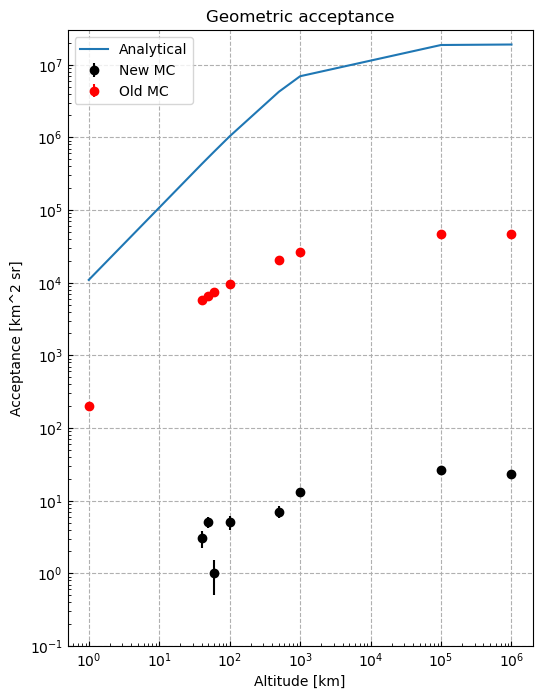

(0.1, 3.0e7)

In [7]:
using PyPlot

alts = ustrip.(altitudes)
newacc = ustrip.([r[2] for r in results])
newerr = ustrip.([r[3] for r in results])
oldacc = ustrip.([r[2] for r in results_old])
olderr = ustrip.([r[3] for r in results_old])

# Plot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["axes.axisbelow"] = true
rcParams["axes.grid"] = true
rcParams["grid.linestyle"] = "dashed"
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"

fig, axs = plt.subplots(1, 1, figsize=(6, 8))
axs.set_title("Geometric acceptance")
axs.loglog(alts, alex, label="Analytical")
axs.errorbar(alts, 2pi*newacc, newerr, fmt="ko", label="New MC")
axs.errorbar(alts, oldacc, olderr, fmt="ro", label="Old MC")
axs.set_ylabel("Acceptance [km^2 sr]")
axs.legend()
axs.set_xlabel("Altitude [km]")
axs.set_ylim(1e-1, 3e7)
 

In [13]:
using Random
using BenchmarkTools

function random_point_on_moon()
    xyz = SVector{3, Float64}(randn(), randn(), randn())
    surface = xyz / norm(xyz)
    return surface
end
function random_unit_vector()
    θ = 2π * rand()
    φ = acos(1 - 2rand())
    return SVector{3, Float64}(sin(φ)*cos(θ), sin(φ)*sin(θ), cos(φ))
end
random_point_on_moon()
random_unit_vector()

LoadError: UndefVarError: SVector not defined

In [64]:
@btime random_point_on_moon()

  14.499 ns (0 allocations: 0 bytes)


3-element SVector{3, Float64} with indices SOneTo(3):
  0.015979756155103268
  0.21870525153212492
 -0.9756601151761269

In [59]:
@btime random_unit_vector()

  55.940 ns (0 allocations: 0 bytes)


3-element SVector{3, Float64} with indices SOneTo(3):
 -0.7986466489553771
 -0.36825468665813244
 -0.4759748059158881

In [71]:
using Unitful
uparse("10")

Int64

In [74]:
a = "orbit:20.0"
parse(Float64, split(a, ":")[2])

20.0

In [77]:
typeof(1km)

Quantity{Int64, 𝐋, Unitful.FreeUnits{(km,), 𝐋, nothing}}

In [78]:
a = [3.235, 6.453, 1.234]
normalize(a)

3-element Vector{Float64}:
 0.44174705841343415
 0.8811727257934748
 0.16850567854163145

In [79]:
a / norm(a)

3-element Vector{Float64}:
 0.4417470584134342
 0.8811727257934748
 0.16850567854163148